### Bibliotecas

In [1]:
import pandas as pd
from datetime import datetime, date
from matplotlib import pyplot as plt
from scipy import stats
from patsy import dmatrices
from xgboost import XGBRegressor, XGBClassifier, plot_importance
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, confusion_matrix, classification_report
from math import sqrt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

### Importação dos Dados e Criação de Variáveis

In [2]:
dataset_dados = pd.read_excel('botafogo_previsao_estadio.xlsx')

In [3]:
dataset_dados = dataset_dados.sort_values(by='data').reset_index(drop=True)

##### Datas

In [4]:
dataset_dados['data'] = pd.to_datetime(dataset_dados['data'])

In [5]:
for i in range(len(dataset_dados)):
    dataset_dados.loc[i, 'dia_semana'] = dataset_dados['data'][i].weekday()
    dataset_dados.loc[i, 'hora'] = int(str(dataset_dados['horario'][0])[:2])
    dataset_dados.loc[i, 'minuto'] = int(str(dataset_dados['horario'][0])[3:5])

In [6]:
dataset_dados['mes'] = dataset_dados['data'].dt.month

In [7]:
dataset_dados['dia_mes'] = dataset_dados['data'].dt.day

##### Resultados de Jogos

In [8]:
dataset_dados['resultado_temporario'] = dataset_dados['gols_mandante'] - dataset_dados['gols_visitantes']

In [9]:
for i in range(len(dataset_dados)):
    if dataset_dados['resultado_temporario'][i] == 0:
        dataset_dados.loc[i, 'resultado_partida'] = 0
    elif dataset_dados['resultado_temporario'][i] > 0:
        dataset_dados.loc[i, 'resultado_partida'] = 1
    else:
        dataset_dados.loc[i, 'resultado_partida'] = -1

In [10]:
dataset_dados.loc[dataset_dados[
    (dataset_dados['time_mandante'] != 'Botafogo') &
    (dataset_dados['resultado_partida'] == 1)
].index, 'resultado_partida'] = -1

In [11]:
dataset_dados.loc[dataset_dados[
    (dataset_dados['time_mandante'] != 'Botafogo') &
    (dataset_dados['resultado_partida'] == -1)
].index, 'resultado_partida'] = 1

Resultados Consecutivos

    Olhando para os últimos 5 jogos como vem sendo o "momento" do time:
        Vitória: 1 ponto
        Empate: 0 ponto
        Derrota: -1 ponto
        
    Valor Máximo: 5 pontos
    Valor Mínimo: -5 pontos

In [12]:
#RESULTADOS CONSECUTIVOS
    
for i in range(len(dataset_dados)):
    valor = dataset_dados['resultado_partida'].shift(5, fill_value=0)[i+0:5+i].sum()
    dataset_dados.loc[i, 'resultados_consecutivos'] = valor
    
#RESULTADO ÚLTIMO JOGO

for i in range(len(dataset_dados)):
    valor = dataset_dados['resultado_partida'].shift(1, fill_value=0)[i+0:5+i].sum()
    dataset_dados.loc[i, 'resultados_ultimo_jogo'] = valor

##### Gols, Colocação e Time Adversário

In [13]:
for i in range(len(dataset_dados)):
    if dataset_dados['time_mandante'][i] == 'Botafogo':
        dataset_dados.loc[i, 'gols_botafogo'] = dataset_dados['gols_mandante'][i]
        dataset_dados.loc[i, 'colocacao_botafogo'] = dataset_dados['colocacao_mandante'][i]
        dataset_dados.loc[i, 'colocacao_adversario'] = dataset_dados['colocacao_visitante'][i]
        dataset_dados.loc[i, 'time_adversario'] = dataset_dados['time_visitante'][i]
    else:
        dataset_dados.loc[i, 'gols_botafogo'] = dataset_dados['gols_visitantes'][i]
        dataset_dados.loc[i, 'colocacao_botafogo'] = dataset_dados['colocacao_visitante'][i]
        dataset_dados.loc[i, 'colocacao_adversario'] = dataset_dados['colocacao_mandante'][i]
        dataset_dados.loc[i, 'time_adversario'] = dataset_dados['time_mandante'][i] 
for i in range(len(dataset_dados)):
    valor = dataset_dados['gols_botafogo'].shift(5, fill_value=0)[i+0:5+i].sum()
    dataset_dados.loc[i, 'gols_botafogo_ultimos_jogos'] = valor

##### Percentual de Ocupacao

In [14]:
dataset_dados['percentual_ocupacao'] = round((dataset_dados['publico'] / dataset_dados['publico_max']) * 100, 2)

##### Jogos de Mando Vendido ou Compartilhado

In [15]:
dados_mando_vendido = dataset_dados[(dataset_dados['resultado_financeiro'] != dataset_dados['custo_botafogo'])]
index = dados_mando_vendido[~dados_mando_vendido['custo_botafogo'].isnull()].index

In [16]:
dataset_dados['mando_vendido_compartilhado'] = False
dataset_dados.loc[index, 'mando_vendido_compartilhado'] = True

##### Prejuízo ou Lucro

In [17]:
index = dataset_dados[dataset_dados['custo_botafogo'] <= 0].index
dataset_dados.loc[index, 'prejuizo_lucro'] = False
index = dataset_dados[dataset_dados['custo_botafogo'] > 0].index
dataset_dados.loc[index, 'prejuizo_lucro'] = True

Competições Internacionais não possuem o borderô publicado a partir de certa data, portanto vamos considerar uma regra:

    Nunca houve prejuízo em jogos com 900000 reais de arrecadação

In [18]:
index = dataset_dados[(dataset_dados['custo_botafogo'].isnull()) &
              (dataset_dados['arrecadacao'] < 900000)
             ].index
dataset_dados.loc[index, 'prejuizo_lucro'] = False
index = dataset_dados[(dataset_dados['custo_botafogo'].isnull()) &
              (dataset_dados['arrecadacao'] >= 900000)
             ].index
dataset_dados.loc[index, 'prejuizo_lucro'] = True

### Dados Usáveis para o Modelo e Tratamentos

In [19]:
dataset_dados = dataset_dados[dataset_dados['time_mandante'] == 'Botafogo']
dataset_dados = dataset_dados.reset_index(drop=True)

##### Distância dos Dias entre o Último Jogo em Casa

In [20]:
dataset_dados['data_ultimo_jogo'] = dataset_dados['data'].shift(1)

In [21]:
dataset_dados.loc[0,'data_ultimo_jogo'] = pd.to_datetime('2022-03-07')

In [22]:
for i in range(len(dataset_dados)):
    dias = (dataset_dados['data'][i] - dataset_dados['data_ultimo_jogo'][i]).days
    dataset_dados.loc[i, 'dias_ultimo_jogo_casa'] = dias

##### Tratamentos

In [23]:
len(dataset_dados)

92

In [24]:
dataset_dados.columns

Index(['ano_campeonato', 'campeonato', 'fase', 'estádio', 'data', 'horario',
       'temperatura', 'jogos_no_mes', 'rodada', 'tipo_partida', 'publico',
       'publico_max', 'arrecadacao', 'despesas', 'impostos',
       'resultado_financeiro', 'custo_botafogo', 'anunciou_poupar',
       'time_mandante', 'time_visitante', 'estado_adversario', 'classico',
       'eliminatorio', 'tecnico_botafogo', 'desfalques', 'colocacao_mandante',
       'colocacao_visitante', 'gols_mandante', 'gols_visitantes', 'dia_semana',
       'hora', 'minuto', 'mes', 'dia_mes', 'resultado_temporario',
       'resultado_partida', 'resultados_consecutivos',
       'resultados_ultimo_jogo', 'gols_botafogo', 'colocacao_botafogo',
       'colocacao_adversario', 'time_adversario',
       'gols_botafogo_ultimos_jogos', 'percentual_ocupacao',
       'mando_vendido_compartilhado', 'prejuizo_lucro', 'data_ultimo_jogo',
       'dias_ultimo_jogo_casa'],
      dtype='object')

In [25]:
dataset_dados = dataset_dados.drop(columns=['resultado_temporario', 'gols_visitantes', 'gols_mandante',
                                           'colocacao_visitante', 'colocacao_mandante', 'time_visitante', 'time_mandante',
                                           'custo_botafogo', 'resultado_financeiro', 'impostos', 'despesas', 'arrecadacao',
                                            'publico_max', 'publico', 'gols_botafogo', 'horario', 'data_ultimo_jogo'])

In [26]:
dataset_dados.columns

Index(['ano_campeonato', 'campeonato', 'fase', 'estádio', 'data',
       'temperatura', 'jogos_no_mes', 'rodada', 'tipo_partida',
       'anunciou_poupar', 'estado_adversario', 'classico', 'eliminatorio',
       'tecnico_botafogo', 'desfalques', 'dia_semana', 'hora', 'minuto', 'mes',
       'dia_mes', 'resultado_partida', 'resultados_consecutivos',
       'resultados_ultimo_jogo', 'colocacao_botafogo', 'colocacao_adversario',
       'time_adversario', 'gols_botafogo_ultimos_jogos', 'percentual_ocupacao',
       'mando_vendido_compartilhado', 'prejuizo_lucro',
       'dias_ultimo_jogo_casa'],
      dtype='object')

In [27]:
dataset_dados.loc[dataset_dados[dataset_dados['anunciou_poupar'] == 'SIM'].index, 'anunciou_poupar'] = True
dataset_dados.loc[dataset_dados[dataset_dados['anunciou_poupar'].isnull()].index, 'anunciou_poupar'] = False
dataset_dados.loc[dataset_dados[dataset_dados['classico'] == 'SIM'].index, 'classico'] = True
dataset_dados.loc[dataset_dados[dataset_dados['classico'].isnull()].index, 'classico'] = False
dataset_dados.loc[dataset_dados[dataset_dados['eliminatorio'] == 'SIM'].index, 'eliminatorio'] = True
dataset_dados.loc[dataset_dados[dataset_dados['eliminatorio'].isnull()].index, 'eliminatorio'] = False

In [28]:
len(dataset_dados.columns)

31

In [29]:
dataset_dados = pd.get_dummies(dataset_dados, columns=['campeonato', 'estádio', 'tipo_partida', 'estado_adversario',
                                                       'tecnico_botafogo', 'time_adversario', 'fase'])

In [30]:
dataset_dados = dataset_dados.astype({'anunciou_poupar': bool,
                                      'classico': bool,
                                      'eliminatorio': bool,
                                       'prejuizo_lucro': bool
                                     })

In [31]:
dataset_previsao = dataset_dados[dataset_dados['data'] >= pd.to_datetime(date.today())]
dataset_dados = dataset_dados[dataset_dados['data'] < pd.to_datetime(date.today())]
dataset_dados = dataset_dados.drop(columns=['data'])
dataset_previsao = dataset_previsao.drop(columns=['data'])
dataset_dados = dataset_dados.reset_index(drop=True)

In [32]:
dataset_dados.head()

,ano_campeonato,temperatura,jogos_no_mes,rodada,anunciou_poupar,classico,eliminatorio,desfalques,dia_semana,hora,...,time_adversario_Ypiranga,fase_fase de grupos,fase_final - taça rio,fase_liga,fase_oitavas-de-final,fase_quartas-de-final,fase_segunda fase,fase_semi-final,fase_semi-final - taça rio,fase_terceira fase
0,2022,26.0,2.0,1,False,True,True,10.0,0.0,16.0,...,False,False,False,False,False,False,False,True,False,False
1,2022,28.0,1.0,1,False,False,False,5.0,6.0,16.0,...,False,False,False,True,False,False,False,False,False,False
2,2022,29.0,1.0,4,False,False,False,7.0,6.0,16.0,...,False,False,False,True,False,False,False,False,False,False
3,2022,23.0,2.0,2,False,False,True,8.0,3.0,16.0,...,False,False,False,False,False,False,False,False,False,True
4,2022,24.0,3.0,6,False,False,False,5.0,6.0,16.0,...,False,False,False,True,False,False,False,False,False,False


In [33]:
len(dataset_dados)

78

In [34]:
dataset_dados.to_csv('dados_modelo_final.csv', index=False)

### Datasets Modelos

Haverão Três Modelos, cada um olhando para uma variável alvo específica, as variáveis alvo serão:

    - percentual_ocupacao: Olhando para tentarmos prever a quantidade de pessoas que irão aos jogos
    - prejuizo_lucro: Olhando para tentarmos prever se o jogo foi rentável (olhando apenas para o contexto do jogo)
    - resultado_partida: Olhando para tentarmos prever o resultado do jogo (Derrota, Vitória ou Empate
    
Sendo assim cada modelo terá seu dataset específico, pois as variáveis alvo não são passíveis de serem utilizadas nos modelos que não sejam os seus por não serem valores disponíveis para a previsão antes do evento acontecer, chamaremos essas varíaveis de indisponíveis.

In [35]:
dados_modelo_percentual_ocupacao = dataset_dados.drop(columns=['prejuizo_lucro', 'resultado_partida']).copy()
dados_modelo_prejuizo_lucro = dataset_dados.drop(columns=['percentual_ocupacao', 'resultado_partida']).copy()
dados_modelo_resultado_partida = dataset_dados.drop(columns=['percentual_ocupacao', 'prejuizo_lucro']).copy()

### Análise Exploratória

##### Funções Úteis

In [36]:
def concentracao_valores (dados, coluna):
    if len(dados[coluna].unique()) > 3:        
        print(dados[coluna].describe())
    else:        
        print(dados[coluna].value_counts())

In [37]:
def correlacao_modelos (dados, coluna):
    print('Menores Valores')
    print('----------------------')
    print(dados.corr()[coluna].sort_values().head(7))
    print('======================')
    print('Maiores Valores')
    print('----------------------')
    print(dados.corr()[coluna].sort_values(ascending=False).head(7))

In [38]:
def visualizacoes (dados, coluna, label):
    if len(dados[coluna].unique()) > 3: 
        fig, ax = plt.subplots()
        ax.hist(dados[coluna])
        ax.set_xlabel(label)
        ax.set_title('Análise Visual - Histograma - '+label)
        plt.show()

In [39]:
def taxas_erro (valores_reais, valores_previstos):
    #RMSE
    rmse = sqrt(mean_squared_error(valores_reais, valores_previstos))
    print('Erro médio quadrático: ', rmse)
    #MAE
    mae = mean_absolute_error(valores_reais, valores_previstos)
    print('Erro médio absoluto: ', mae)

Esse artigo me ajudou com a tunagem dos hiperparâmetros:

    - https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/

In [40]:
def tunning_hiperpametros (modelo, X_train, y_train):
    
    print('Testando Variáveis: max_depth, min_child_weight')
    
    param_test = {
     'max_depth':range(3,10,2),
     'min_child_weight':range(1,6,2),
    }
    
    gsearch = GridSearchCV(estimator = modelo(
                    learning_rate=0.01, max_depth=5, n_estimators=200, n_jobs=-1, random_state=1, seed=42,
                    min_child_weight=1, gamma = 0, subsample = 0.8, colsample_bytree = 0.8, scale_pos_weight = 1
                   ), 
                    param_grid = param_test, scoring='roc_auc', n_jobs=-1, cv=10)      
    gsearch.fit(X_train, y_train)
        
    max_depth = gsearch.best_params_['max_depth']
    min_child_weight = gsearch.best_params_['min_child_weight']
    
    print('Melhores valores: ', gsearch.best_params_)
    
    print('-----------------------------')  
    
    print('Testando Variáveis:gamma')
    
    param_test = {
     'gamma':[i/10.0 for i in range(0,5)],
    }
    
    gsearch = GridSearchCV(estimator = modelo(
                    learning_rate=0.01, max_depth=max_depth, n_estimators=200, n_jobs=-1, random_state=1, seed=42,
                    min_child_weight=min_child_weight, gamma = 0 , subsample = 0.8, colsample_bytree = 0.8, scale_pos_weight = 1
                   ), 
                    param_grid = param_test, scoring='roc_auc', n_jobs=-1, cv=10)      
    gsearch.fit(X_train, y_train)
    
    print('Melhores valores: ', gsearch.best_params_)
    gamma = gsearch.best_params_['gamma']
    
    print('-----------------------------')  
    
    print('Testando Variáveis: subsample, colsample_bytree')
    
    param_test = {
     'subsample':[i/10.0 for i in range(6,10)],
     'colsample_bytree':[i/10.0 for i in range(6,10)]
    }
    
    gsearch = GridSearchCV(estimator = modelo(
                    learning_rate=0.01, max_depth=max_depth, n_estimators=200, n_jobs=-1, random_state=1, seed=42,
                    min_child_weight=min_child_weight, gamma = gamma, subsample = 0.8, colsample_bytree = 0.8, scale_pos_weight = 1
                   ), 
                    param_grid = param_test, scoring='roc_auc', n_jobs=-1, cv=10)      
    gsearch.fit(X_train, y_train)
    
    print('Melhores valores: ', gsearch.best_params_)
    
    print('-----------------------------')  
    
    print('Testando Variáveis: reg_alpha')
    
    param_test = {
     'reg_alpha':[1e-5, 1e-2, 0.1, 1, 100]
    }
    
    gsearch = GridSearchCV(estimator = modelo(
                    learning_rate=0.01, max_depth=max_depth, n_estimators=200, n_jobs=-1, random_state=1, seed=42,
                    min_child_weight=min_child_weight, gamma = gamma, subsample = gsearch.best_params_['subsample'],
                    colsample_bytree = gsearch.best_params_['colsample_bytree'], scale_pos_weight = 1
                   ), 
                    param_grid = param_test, scoring='roc_auc', n_jobs=-1, cv=10)      
    gsearch.fit(X_train, y_train)
    
    print('Melhores valores: ', gsearch.best_params_)
    
    print('-----------------------------')  

##### Modelo 1

In [41]:
concentracao_valores(dados_modelo_percentual_ocupacao, 'percentual_ocupacao')

count    78.000000
mean     44.752564
std      23.381025
min       8.140000
25%      27.210000
50%      41.745000
75%      61.950000
max      91.780000
Name: percentual_ocupacao, dtype: float64


In [42]:
correlacao_modelos(dados_modelo_percentual_ocupacao, 'percentual_ocupacao')

Menores Valores
----------------------
campeonato_carioca              -0.512334
estado_adversario_RJ            -0.368959
time_adversario_Portuguesa-RJ   -0.310216
temperatura                     -0.308373
mando_vendido_compartilhado     -0.285712
anunciou_poupar                 -0.280157
estádio_Raulino de Oliveira     -0.252735
Name: percentual_ocupacao, dtype: float64
Maiores Valores
----------------------
percentual_ocupacao                1.000000
mes                                0.448263
tecnico_botafogo_Bruno Lage        0.374305
campeonato_serie a                 0.372187
rodada                             0.286101
tecnico_botafogo_Cláudio Caçapa    0.251687
colocacao_adversario               0.231352
Name: percentual_ocupacao, dtype: float64


In [43]:
dados_modelo_percentual_ocupacao.corr()['percentual_ocupacao']

ano_campeonato               -0.091408
temperatura                  -0.308373
jogos_no_mes                 -0.000552
rodada                        0.286101
anunciou_poupar              -0.280157
                                ...   
fase_quartas-de-final         0.044432
fase_segunda fase            -0.088210
fase_semi-final              -0.131483
fase_semi-final - taça rio   -0.243238
fase_terceira fase           -0.009033
Name: percentual_ocupacao, Length: 116, dtype: float64

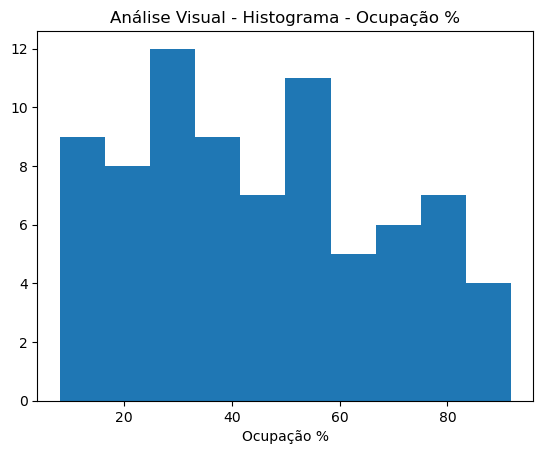

In [44]:
visualizacoes(dados_modelo_percentual_ocupacao, 'percentual_ocupacao', 'Ocupação %')

##### Modelo 2 

In [45]:
concentracao_valores(dados_modelo_prejuizo_lucro, 'prejuizo_lucro')

prejuizo_lucro
True     40
False    38
Name: count, dtype: int64


In [46]:
correlacao_modelos(dados_modelo_prejuizo_lucro, 'prejuizo_lucro')

Menores Valores
----------------------
eliminatorio              -0.394156
anunciou_poupar           -0.370463
temperatura               -0.358215
campeonato_carioca        -0.330635
tipo_partida_volta        -0.316723
estádio_Luso Brasileiro   -0.205196
fase_segunda fase         -0.205196
Name: prejuizo_lucro, dtype: float64
Maiores Valores
----------------------
prejuizo_lucro         1.000000
tipo_partida_liga      0.394156
campeonato_serie a     0.332902
mes                    0.290858
fase_fase de grupos    0.281366
rodada                 0.274625
classico               0.271729
Name: prejuizo_lucro, dtype: float64


##### Modelo 3

In [47]:
concentracao_valores(dados_modelo_resultado_partida, 'resultado_partida')

resultado_partida
 1.0    41
-1.0    21
 0.0    16
Name: count, dtype: int64


In [48]:
correlacao_modelos(dados_modelo_resultado_partida, 'resultado_partida')

Menores Valores
----------------------
tecnico_botafogo_Lúcio Flávio   -0.368411
rodada                          -0.304542
time_adversario_Flamengo        -0.294280
mes                             -0.250202
classico                        -0.249436
time_adversario_Cuiabá-MT       -0.238692
estado_adversario_MT            -0.238692
Name: resultado_partida, dtype: float64
Maiores Valores
----------------------
resultado_partida              1.000000
resultados_ultimo_jogo         0.585005
jogos_no_mes                   0.317677
ano_campeonato                 0.317602
gols_botafogo_ultimos_jogos    0.298121
dia_mes                        0.232589
eliminatorio                   0.219284
Name: resultado_partida, dtype: float64


### Modelagem

##### Modelo 1

In [49]:
X = dados_modelo_percentual_ocupacao.drop(columns=['percentual_ocupacao']).copy()
y = dados_modelo_percentual_ocupacao[['percentual_ocupacao']]

In [50]:
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, random_state=42)
eval_set = [(X_test, y_test)]

In [51]:
tunning_hiperpametros(XGBRegressor, X_train, y_train)

Testando Variáveis: max_depth, min_child_weight
Melhores valores:  {'max_depth': 3, 'min_child_weight': 1}
-----------------------------
Testando Variáveis:gamma
Melhores valores:  {'gamma': 0.0}
-----------------------------
Testando Variáveis: subsample, colsample_bytree
Melhores valores:  {'colsample_bytree': 0.6, 'subsample': 0.6}
-----------------------------
Testando Variáveis: reg_alpha
Melhores valores:  {'reg_alpha': 1e-05}
-----------------------------


In [52]:
model = XGBRegressor(verbosity=0, learning_rate=0.01, max_depth=3, n_estimators=10000, n_jobs=-1, random_state=1,
                    min_child_weight=1, gamma = 0.0, subsample = 0.6, colsample_bytree = 0.6, scale_pos_weight = 1,
                    reg_alpha= 1e-05)
model.fit(X_train, y_train, 
          early_stopping_rounds=10,
          eval_set=eval_set, eval_metric='rmse', verbose = 1)

[0]	validation_0-rmse:25.71777
[1]	validation_0-rmse:25.73358
[2]	validation_0-rmse:25.65874
[3]	validation_0-rmse:25.60549
[4]	validation_0-rmse:25.49405
[5]	validation_0-rmse:25.43327
[6]	validation_0-rmse:25.29449
[7]	validation_0-rmse:25.21524
[8]	validation_0-rmse:25.16011
[9]	validation_0-rmse:25.16309
[10]	validation_0-rmse:25.05383
[11]	validation_0-rmse:25.03024
[12]	validation_0-rmse:24.89891
[13]	validation_0-rmse:24.80901
[14]	validation_0-rmse:24.69311
[15]	validation_0-rmse:24.65151
[16]	validation_0-rmse:24.57931
[17]	validation_0-rmse:24.56190
[18]	validation_0-rmse:24.48216
[19]	validation_0-rmse:24.44153
[20]	validation_0-rmse:24.34866
[21]	validation_0-rmse:24.35540
[22]	validation_0-rmse:24.36750
[23]	validation_0-rmse:24.28375
[24]	validation_0-rmse:24.23830
[25]	validation_0-rmse:24.18039
[26]	validation_0-rmse:24.17583
[27]	validation_0-rmse:24.18371
[28]	validation_0-rmse:24.12085
[29]	validation_0-rmse:23.98224
[30]	validation_0-rmse:23.94734
[31]	validation_0-

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.6, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=0.0, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=1, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=10000, n_jobs=-1,
             num_parallel_tree=None, random_state=1, ...)

In [53]:
model.feature_importances_

array([0.01096492, 0.01020547, 0.01137291, 0.01549391, 0.01759438,
       0.01220062, 0.        , 0.01514646, 0.02552548, 0.        ,
       0.        , 0.03680514, 0.02106709, 0.01808939, 0.01371078,
       0.02519996, 0.01375761, 0.01535419, 0.0222099 , 0.01732052,
       0.03772581, 0.        , 0.01052293, 0.01720645, 0.00305918,
       0.00604246, 0.        , 0.        , 0.00541709, 0.        ,
       0.01771804, 0.0173145 , 0.        , 0.01316181, 0.        ,
       0.        , 0.02243529, 0.        , 0.        , 0.00802788,
       0.01024372, 0.00606513, 0.        , 0.        , 0.        ,
       0.        , 0.01492342, 0.        , 0.        , 0.0085801 ,
       0.01084708, 0.03348638, 0.01286361, 0.        , 0.01794622,
       0.01831054, 0.02455339, 0.01468677, 0.01539457, 0.0353056 ,
       0.01681703, 0.02724498, 0.        , 0.03962703, 0.01698104,
       0.        , 0.        , 0.        , 0.        , 0.00111901,
       0.        , 0.        , 0.        , 0.0003899 , 0.02287

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

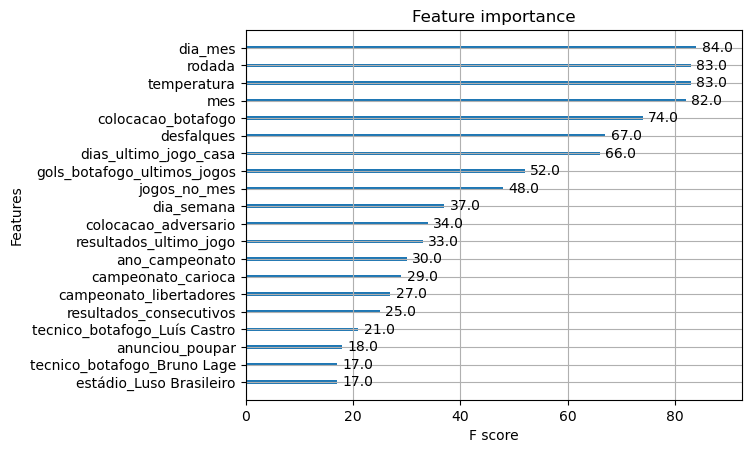

In [54]:
plot_importance(model, max_num_features=20)

In [55]:
score = model.score(X_train, y_train)  
score

0.691606725049065

In [56]:
y_pred = model.predict(X_test)
predictions = [round(value, 2) for value in y_pred]
len(predictions)

16

Text(0.5, 1.0, 'Previsão Ocupação')

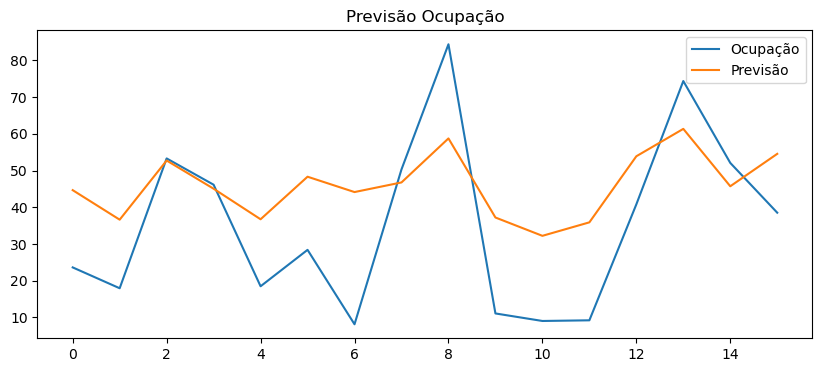

In [57]:
y_test = y_test.reset_index(drop=True)
fig, ax = plt.subplots(figsize=(10, 4))
ax.plot(y_test, label='Ocupação')
ax.plot(predictions, label='Previsão')
ax.legend()
ax.set_title("Previsão Ocupação")

In [58]:
taxas_erro(y_test, predictions)

Erro médio quadrático:  19.462970262112506
Erro médio absoluto:  16.829375467300416


##### Previsões

In [59]:
dataset_previsao_modelo = dataset_previsao.drop(columns=['percentual_ocupacao', 'prejuizo_lucro', 'resultado_partida']
                                               ).copy().reset_index(drop=True).loc[:0]

In [60]:
model.predict(dataset_previsao_modelo)

array([58.849045], dtype=float32)

##### Modelo 2

In [61]:
dados_modelo_prejuizo_lucro = dados_modelo_prejuizo_lucro[~dados_modelo_prejuizo_lucro['prejuizo_lucro'].isna() == True].reset_index(drop=True)

In [62]:
X = dados_modelo_prejuizo_lucro.drop(columns=['prejuizo_lucro']).copy()
y = dados_modelo_prejuizo_lucro[['prejuizo_lucro']]

In [63]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
eval_set = [(X_test, y_test)]

In [64]:
tunning_hiperpametros(XGBClassifier, X_train, y_train)

Testando Variáveis: max_depth, min_child_weight
Melhores valores:  {'max_depth': 5, 'min_child_weight': 1}
-----------------------------
Testando Variáveis:gamma
Melhores valores:  {'gamma': 0.0}
-----------------------------
Testando Variáveis: subsample, colsample_bytree
Melhores valores:  {'colsample_bytree': 0.6, 'subsample': 0.8}
-----------------------------
Testando Variáveis: reg_alpha
Melhores valores:  {'reg_alpha': 1e-05}
-----------------------------


In [65]:
model = XGBClassifier(verbosity=0, learning_rate=0.01, max_depth=5, n_estimators=10000, n_jobs=-1, random_state=1,
                    min_child_weight=1, gamma = 0.0, subsample = 0.8, colsample_bytree = 0.6, scale_pos_weight = 1,
                    reg_alpha= 1e-05)

model.fit(X_train, y_train, 
          early_stopping_rounds=10,
          eval_set=eval_set, eval_metric='auc', verbose = 1)

[0]	validation_0-auc:0.70000
[1]	validation_0-auc:0.70833
[2]	validation_0-auc:0.83333
[3]	validation_0-auc:0.98333
[4]	validation_0-auc:0.75000
[5]	validation_0-auc:0.91667
[6]	validation_0-auc:0.96667
[7]	validation_0-auc:0.90000
[8]	validation_0-auc:0.96667
[9]	validation_0-auc:0.93333
[10]	validation_0-auc:0.90000
[11]	validation_0-auc:0.88333
[12]	validation_0-auc:0.96667


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.6, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0.0, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.01, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=10000, n_jobs=-1,
              num_parallel_tree=None, random_state=1, ...)

In [66]:
model.feature_importances_

array([0.02033694, 0.0637558 , 0.02821984, 0.07878763, 0.06759928,
       0.09426209, 0.        , 0.02876934, 0.05241304, 0.        ,
       0.        , 0.08345693, 0.05101383, 0.01024022, 0.0846976 ,
       0.04854617, 0.04156802, 0.04740593, 0.        , 0.03908651,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.03864672,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.     

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

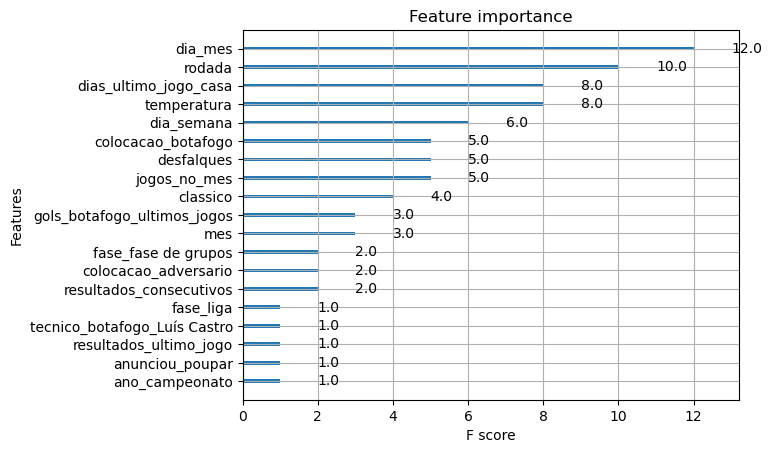

In [67]:
plot_importance(model, max_num_features=20)

In [68]:
score = model.score(X_train, y_train)  
score

0.5483870967741935

In [69]:
y_pred = model.predict(X_test)
predictions = [round(value, 2) for value in y_pred]
len(predictions)

16

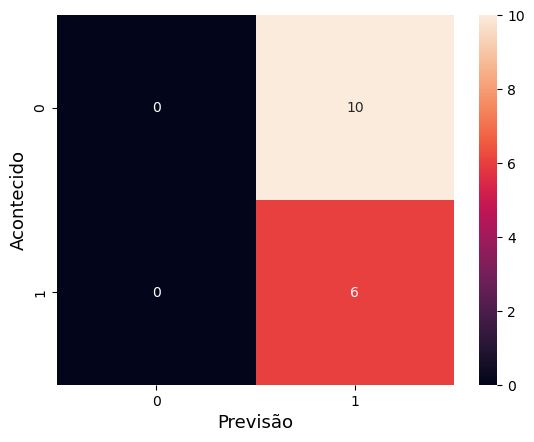

In [70]:
sns.heatmap(confusion_matrix(y_test, predictions), 
            annot=True,
            fmt='g')
plt.ylabel('Acontecido',fontsize=13)
plt.xlabel('Previsão',fontsize=13)
plt.show()

In [71]:
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

       False       0.00      0.00      0.00        10
        True       0.38      1.00      0.55         6

    accuracy                           0.38        16
   macro avg       0.19      0.50      0.27        16
weighted avg       0.14      0.38      0.20        16



##### Previsões

In [72]:
model.predict(dataset_previsao_modelo)

array([1])

##### Modelo 3

In [73]:
X = dados_modelo_resultado_partida.drop(columns=['resultado_partida']).copy()
y = dados_modelo_resultado_partida[['resultado_partida']]

In [74]:
y.loc[y[y['resultado_partida'] == -1].index, 'resultado_partida'] = 2

In [75]:
y['resultado_partida'] = y['resultado_partida'].astype(int)

In [76]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
eval_set = [(X_test, y_test)]

In [77]:
tunning_hiperpametros(XGBClassifier, X_train, y_train)

Testando Variáveis: max_depth, min_child_weight
Melhores valores:  {'max_depth': 3, 'min_child_weight': 1}
-----------------------------
Testando Variáveis:gamma
Melhores valores:  {'gamma': 0.0}
-----------------------------
Testando Variáveis: subsample, colsample_bytree
Melhores valores:  {'colsample_bytree': 0.6, 'subsample': 0.6}
-----------------------------
Testando Variáveis: reg_alpha
Melhores valores:  {'reg_alpha': 1e-05}
-----------------------------


In [78]:
model = XGBClassifier(verbosity=0, learning_rate=0.01, max_depth=3, n_estimators=10000, n_jobs=-1, random_state=1,
                    min_child_weight=1, gamma = 0., subsample = 0.6, colsample_bytree = 0.6, scale_pos_weight = 1,
                    reg_alpha= 1e-05)

model.fit(X_train, y_train, 
          early_stopping_rounds=10,
          eval_set=eval_set, eval_metric='auc', verbose = 1)

[0]	validation_0-auc:0.69681
[1]	validation_0-auc:0.77620
[2]	validation_0-auc:0.63573
[3]	validation_0-auc:0.61790
[4]	validation_0-auc:0.62879
[5]	validation_0-auc:0.67708
[6]	validation_0-auc:0.67582
[7]	validation_0-auc:0.69318
[8]	validation_0-auc:0.71102
[9]	validation_0-auc:0.69839
[10]	validation_0-auc:0.72317


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.6, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0.0, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.01, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=10000, n_jobs=-1,
              num_parallel_tree=None, objective='multi:softprob', ...)

In [79]:
model.feature_importances_

array([0.06440157, 0.02649638, 0.02453469, 0.04184848, 0.        ,
       0.04032499, 0.        , 0.04141705, 0.02767071, 0.        ,
       0.        , 0.04090466, 0.05861609, 0.03256984, 0.09951118,
       0.03997768, 0.02895662, 0.031821  , 0.        , 0.02124842,
       0.04248986, 0.        , 0.        , 0.        , 0.        ,
       0.0416107 , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.03721806, 0.        , 0.        , 0.        ,
       0.01140228, 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.01383657, 0.        ,
       0.03220648, 0.        , 0.        , 0.03756999, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.     

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

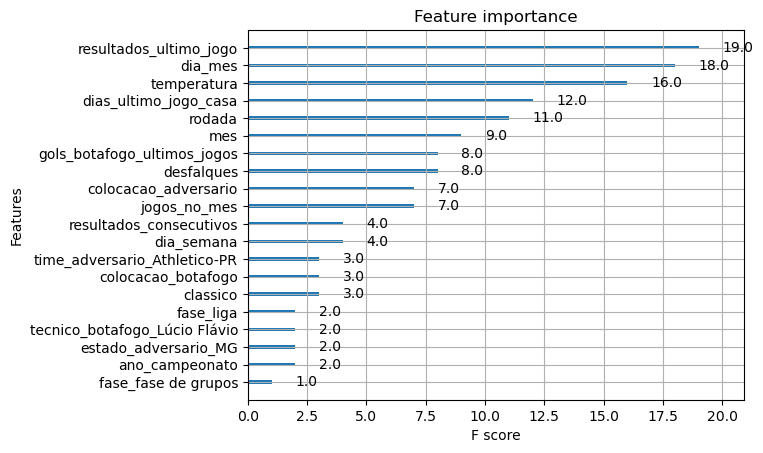

In [80]:
plot_importance(model, max_num_features=20)

In [81]:
score = model.score(X_train, y_train)  
score

0.7580645161290323

In [82]:
y_pred = model.predict(X_test)
predictions = [round(value, 2) for value in y_pred]
len(predictions)

16

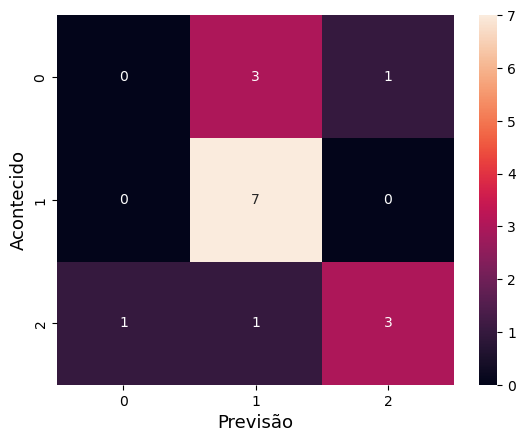

In [83]:
sns.heatmap(confusion_matrix(y_test, predictions), 
            annot=True,
            fmt='g')
plt.ylabel('Acontecido',fontsize=13)
plt.xlabel('Previsão',fontsize=13)
plt.show()

In [84]:
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         4
           1       0.64      1.00      0.78         7
           2       0.75      0.60      0.67         5

    accuracy                           0.62        16
   macro avg       0.46      0.53      0.48        16
weighted avg       0.51      0.62      0.55        16



##### Previsões

In [85]:
model.predict(dataset_previsao_modelo)

array([2], dtype=int64)